In [1]:
import torch
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from src.hog.hog import test_hog, load_hog
from src.hog.hog_op import compute_hog_character

from src.utils.load_data import get_test_data
from src.utils.char_extraction import pre_process
from src.utils.char_to_int import convert_int_to_char

from src.nn.model import CaptchaClassifierBigger

# Load Data

In [2]:
X_test, y_test = get_test_data()

test_images_ground_truth_files = sorted(glob.glob('./dados/teste/*.jpg'))
test_images_ground_truth = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in test_images_ground_truth_files ]

test_label_files = sorted(glob.glob('./dados/labels10k/*.txt'))[9000:]
test_labels = [open(label_file).read().strip() for label_file in test_label_files]

# Pre process

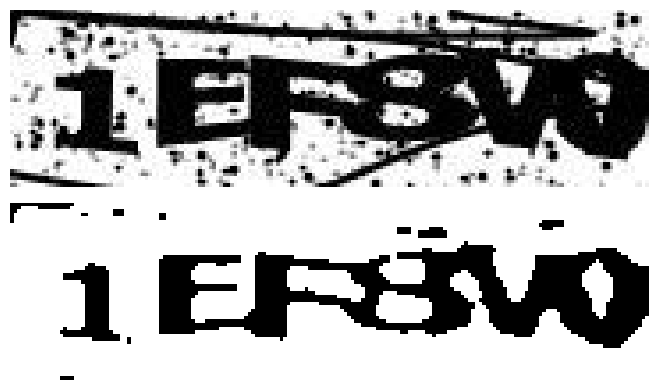

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4))

axes[0].imshow(test_images_ground_truth[2], cmap='gray')
axes[0].axis('off')

img = pre_process(test_images_ground_truth[2])

axes[1].imshow(img, cmap='gray')
axes[1].axis('off')

plt.tight_layout()
plt.show()

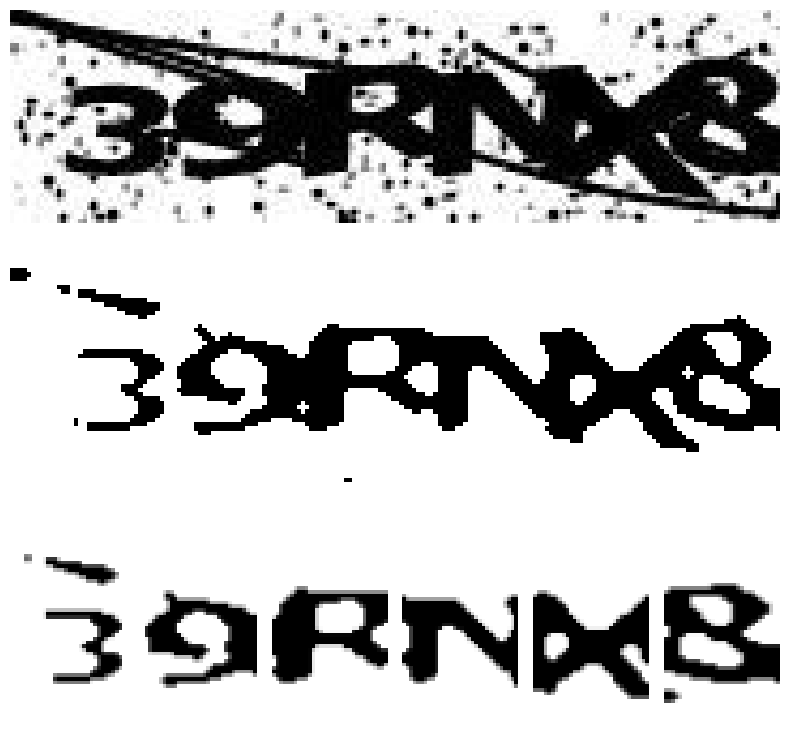

In [4]:
def results_nn(idx_image):
    offset = 6 * idx_image
    
    fig = plt.figure(figsize=(8, 8))
    
    # 1st line (ground truth image)
    ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=6)
    ax1.imshow(test_images_ground_truth[offset//6], cmap='gray')
    ax1.axis('off')
    
    # 2nd line (pre-processed image)
    ax2 = plt.subplot2grid((3, 6), (1, 0), colspan=6)
    ax2.imshow(pre_process(test_images_ground_truth[offset//6]), cmap='gray')
    ax2.axis('off')
    
    # 3rd line (6 subplots)
    for i in range(6):
        ax = plt.subplot2grid((3, 6), (2, i))
        ax.imshow(X_test[i+offset], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

results_nn(188)

# Hog

In [5]:
hog_classifier_path = 'models/captcha_classifier_hog.pkl'
classifier = load_hog(hog_classifier_path)

accuracy = test_hog(classifier, X_test, y_test)

/home/lorenzo/anaconda3/envs/ecg/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
100%|██████████| 6000/6000 [00:01<00:00, 3240.79it/s]


Accuracy: 93.02%


In [6]:
def results_hog(idx_image):
    offset = 6 * idx_image
    
    preds = []
    for i in range(6):
        features = compute_hog_character(X_test[i+offset])
        features = features.reshape(1, -1)
        pred = classifier.predict(features)
        preds.append(pred[0])
            
    pred_string = ''.join(preds)
    print("Predictions:", pred_string)
    print("Ground Truth label: ", test_labels[offset//6])
    
    num_errors = 0
    for i in range(len(pred_string)):
        if pred_string[i] != test_labels[offset//6][i]:
            num_errors += 1

    if not num_errors:
        print('Acertou todos')
    else:
        print(f'Errou {num_errors} vezes')

In [7]:
results_hog(31)

Predictions: FT33KX
Ground Truth label:  FT3BKX
Errou 1 vezes


# NN

In [8]:
model = CaptchaClassifierBigger()
model.load_state_dict(torch.load('models/nn_model_bigger.pth'))
model.eval()
model.to('cuda')

CaptchaClassifierBigger(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=36, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Predictions: Z161HP
Ground Truth label:  Z161HP
Acertou todos


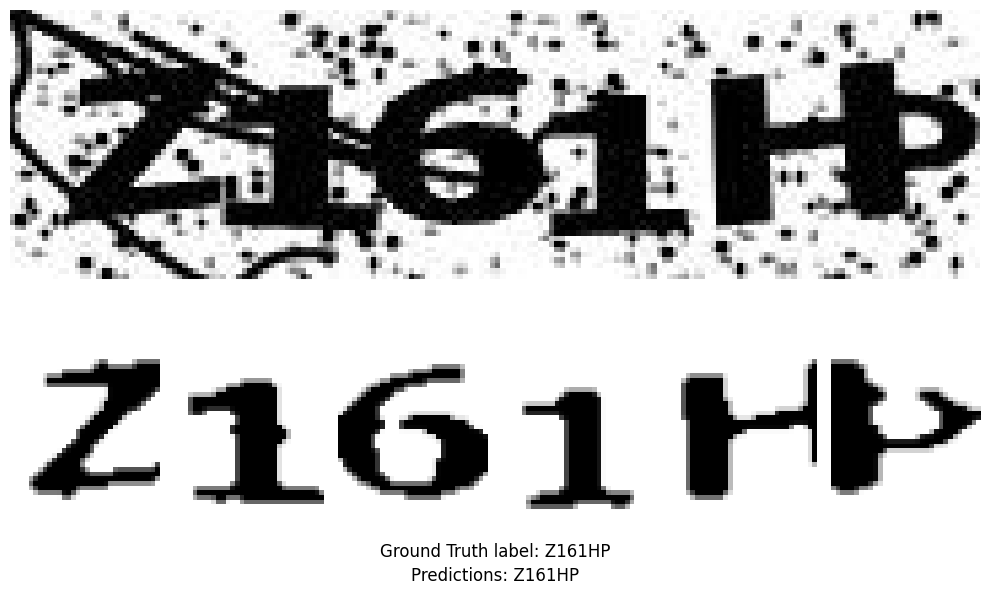

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def results_nn(idx_image):
    offset = 6 * idx_image
    
    fig = plt.figure(figsize=(10, 6))
    
    ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=1)
    ax1.imshow(test_images_ground_truth[offset//6], cmap='gray')
    ax1.axis('off')
    
    preds = []
    for i in range(6):
        ax = plt.subplot2grid((2, 6), (1, i))
        ax.imshow(X_test[i+offset], cmap='gray')
        ax.axis('off')
        
        with torch.no_grad():
            tensor = transform(X_test[i+offset]).to('cuda')
            outputs = model(tensor.unsqueeze(0))
            _, pred = torch.max(outputs, 1)
            char_pred = convert_int_to_char(int(pred))
            preds.append(char_pred)

    plt.tight_layout()
    
    pred_string = ''.join(preds)
    ground_truth_label = test_labels[offset//6]
    
    plt.figtext(0.5, 0.01, f'Predictions: {pred_string}', ha='center', fontsize=12)
    plt.figtext(0.5, 0.05, f'Ground Truth label: {ground_truth_label}', ha='center', fontsize=12)
    
    plt.savefig('./images/ground_truth_vs_filtered_with_pred.png', bbox_inches='tight')
    

    print("Predictions:", pred_string)
    print("Ground Truth label: ", ground_truth_label)
    
    num_errors = 0
    for i in range(len(pred_string)):
        if pred_string[i] != ground_truth_label[i]:
            num_errors += 1

    if not num_errors:
        print('Acertou todos')
    else:
        print(f'Errou {num_errors} vezes')
        
results_nn(315)

# Plot accuracy by number of digits

In [11]:
def predict_hog(data):
    features = compute_hog_character(data)
    features = features.reshape(1, -1)
    pred = classifier.predict(features)
    return pred[0]

def predict_nn(data):
    tensor = transform(data).to('cuda')
    outputs = model(tensor.unsqueeze(0))
    _, pred = torch.max(outputs, 1)
    char_pred = convert_int_to_char(int(pred))
    return char_pred

In [29]:
def recognition(predict_function):
    recognitions = []
    recognitions.append(100)
    
    for num_digits in [1, 2, 3, 4, 5, 6]:
        digit_recog = []
        for idx in range(len(test_labels)):
            offset = 6 * idx
        
            preds = []
            num_errors = 0
            recog = 1
            
            indices = list(range(num_digits))
            np.random.shuffle(indices)
            
            for i in indices:
                with torch.no_grad():
                    pred = predict_function(X_test[i+offset])
                    preds.append(pred)
                    
                    if pred != test_labels[offset//6][i]:
                        num_errors += 1
            
            if num_errors > 0:
                recog = 0
                
            digit_recog.append(recog)
                    
        recognitions.append(np.sum(digit_recog)/len(test_labels) * 100)
        
    return recognitions
            

In [42]:
def accuracy_per_digit(predict_function):
    
    corrects = []
    
    for idx in range(len(test_labels)):
        offset = 6 * idx
    
        preds = []
        num_correct = 0
        
        for i in range(6):
            with torch.no_grad():
                pred = predict_function(X_test[i+offset])
                preds.append(pred)
                
                if pred == test_labels[offset//6][i]:
                    num_correct += 1
            
        corrects.append(num_correct)
    
    
    len_corrects = len(corrects)
    corrects = np.array(corrects)
    
    accuracies = []
    
    for num_correct_digits in range(0, 7):
        corrects_digit = np.sum(corrects >= num_correct_digits)
        accuracies.append(corrects_digit/len_corrects * 100)
            
    return accuracies

In [43]:
accuracies_hog = accuracy_per_digit(predict_hog)
recognitions_hog = recognition(predict_hog)

In [44]:
accuracies_nn = accuracy_per_digit(predict_nn)
recognitions_nn = recognition(predict_nn)

In [45]:
def plot_by_num_digits(accuracies_hog, accuracies_nn, feature):
    x = [0, 1, 2, 3, 4, 5, 6]
    
    plt.figure(figsize=(10, 6))

    sns.lineplot(x=x, y=accuracies_hog, marker='o', label='HOG', color='blue')

    sns.lineplot(x=x, y=accuracies_nn, marker='o', label='NN', color='orange')
    
    plt.grid(True)
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}%'))

    # Add title and labels
    plt.title(f'{feature} Comparison of HOG and NN Models by Number of Digits')
    plt.xlabel('Number of Digits')
    plt.ylabel(f'{feature} (%)')

    plt.legend(title='Model')
    
    plt.savefig(f'./images/{feature}_hog_vs_nn.png', bbox_inches='tight')

    plt.show()

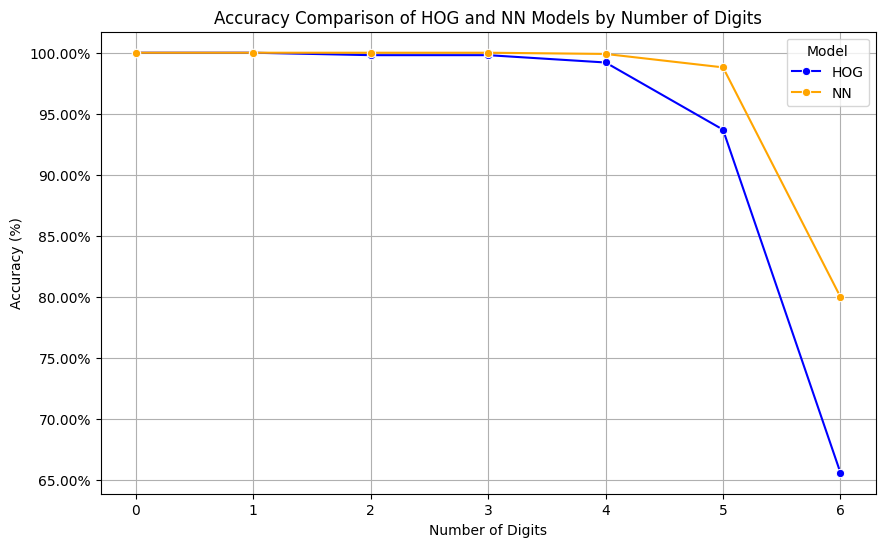

In [46]:
plot_by_num_digits(accuracies_hog, accuracies_nn, 'Accuracy')

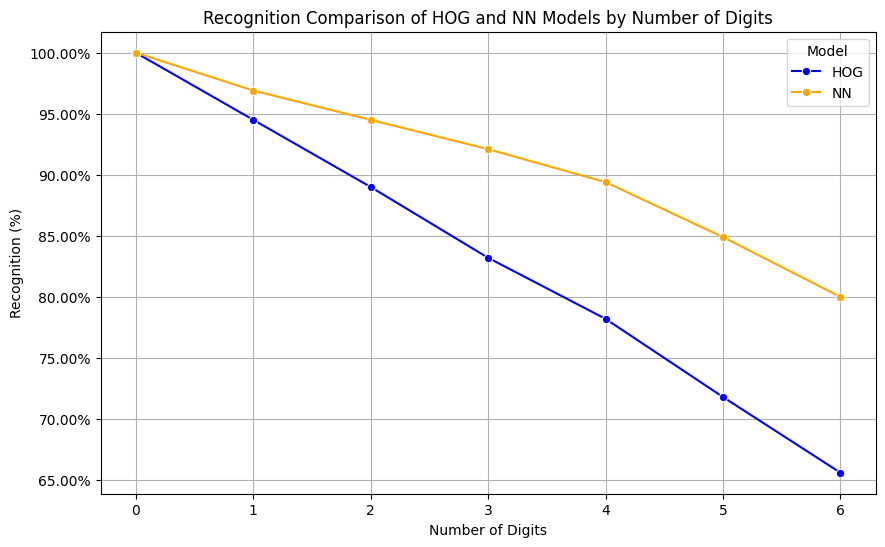

In [47]:
plot_by_num_digits(recognitions_hog, recognitions_nn, 'Recognition')